# Tugas 8: Word Graph

In [73]:
# %%capture
# !pip install --upgrade pymupdf
# !pip install nltk
# !pip install networkx
# !pip install matplotlib
# !pip install Sastrawi

In [74]:
# Import semua library
import pymupdf
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\willy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\willy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [75]:
doc = pymupdf.open("data/jurnal.pdf") # open a document
out = open("output.txt", "wb") # create a text output
for page in doc: # iterate the document pages
    text = page.get_text().encode("utf8") # get plain text (is in UTF-8)
    out.write(text) # write text of page
    out.write(bytes((12,))) # write page delimiter (form feed 0x0C)
out.close()

In [76]:
with open('output.txt', 'r', encoding='utf-8') as file:
    teks = file.read()

print(teks[:200])  # tampilkan 200 karakter pertama

Jurnal Farmasi IKIFA 
Vol. 3 No. 3 Oktober 2024 
 
 
Ida, dkk | 121  
 
HUBUNGAN KARAKTERISTIK DEMOGRAFI DENGAN PENGETAHUAN 
MASYARAKAT TENTANG HIV/AIDS  DI RW 02  KELURAHAN PINANG RANTI 
JAKARTA-TIMU


In [77]:
sentences = nltk.sent_tokenize(teks)
print(sentences)

['Jurnal Farmasi IKIFA \nVol.', '3 No.', '3 Oktober 2024 \n \n \nIda, dkk | 121  \n \nHUBUNGAN KARAKTERISTIK DEMOGRAFI DENGAN PENGETAHUAN \nMASYARAKAT TENTANG HIV/AIDS  DI RW 02  KELURAHAN PINANG RANTI \nJAKARTA-TIMUR \n \nIda Diana Sari1, Nina Rustiana2, Aulia Eka Damayanti3 \n1,2,3Program Studi Farmasi, Sekolah Tinggi Ilmu Kesehatan IKIFA \nEmail : idadiana@ikifa.ac.id \nEmail: ninarustiana@ikifa.ac.id \nEmail: auliaeka.9b@gmail.com \n \nABSTRAK \nHuman Immunodeficiency Virus (HIV) yaitu virus yang menyerang dan melemahkan sistem \npertahanan tubuh manusia, sehingga tubuh mudah tertular berbagai penyakit.', 'Pada akhir tahun \n2022 sebanyak 85,6 juta orang telah terinfeksi virus HIV dan sekitar 40,4 juta orang meninggal \nkarena HIV.', 'Prevalensi orang hidup dengan HIV secara global sebanyak 39,0 juta.', 'Menurut \nLaporan Eksekutif Perkembangan HIV/AIDS dan Penyakit Menular Seksual (PIMS) Triwulan I \ntahun 2023, tercatat 5 Provinsi yang melaporkan kasus HIV tertinggi di Indonesia 

In [78]:
df = pd.DataFrame(sentences, columns=['kalimat'])

# Buang baris dimana panjang kata kurang dari 3
df['jumlah_kata'] = df['kalimat'].apply(lambda x: len(x.split()))
df = df[df['jumlah_kata'] >= 12].drop(columns=['jumlah_kata']).reset_index(drop=True)

print(f"Jumlah kalimat setelah filter: {len(df)}")
print(df)

Jumlah kalimat setelah filter: 94
                                              kalimat
0   3 Oktober 2024 \n \n \nIda, dkk | 121  \n \nHU...
1   Pada akhir tahun \n2022 sebanyak 85,6 juta ora...
2   Menurut \nLaporan Eksekutif Perkembangan HIV/A...
3   Tujuan dari penelitian ini adalah Untuk menget...
4   Terdapat 342 sampel dalam penelitian ini, yang...
..                                                ...
89  Gambaran Tingkat Pengetahuan Masyarakat Tentan...
90  Susanti, S. Karakteristik Penderita HIV/AIDS D...
91  Dr. R. Haryo Bimo Setiarto, S.Si., M.Si., Dr. ...
92  HANDITYA, B.; SACIPTO, R. Penanggulangan dan p...
93  3 Oktober 2024 \n \n \nIda, dkk | 131  \n \nte...

[94 rows x 1 columns]


In [79]:
df.to_csv('kalimat.csv', index=False, encoding='utf-8')

Untuk membuat word graph

Lanjutkan dengan menggunakan https://www.geeksforgeeks.org/nlp/co-occurence-matrix-in-nlp/

In [80]:
# Baca teks dari paper PDF (output.txt yang sudah diextract sebelumnya)
with open('output.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Preprocess the text - menggunakan stopwords Sastrawi (Bahasa Indonesia)
factory = StopWordRemoverFactory()
stop_words = set(factory.get_stop_words())

# Inisialisasi Stemmer Sastrawi
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

words = word_tokenize(text.lower())
# Filter: hanya alphabetic (bukan angka), bukan stopwords, panjang > 2
words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]

# Stemming setiap kata
# print("Melakukan stemming...")
# words = [stemmer.stem(word) for word in words]

print(f"Total kata setelah pre processing: {len(words)}")
print(f"Kata unik: {len(set(words))}")

# Define the window size for co-occurrence
window_size = 2

# Create a list of co-occurring word pairs
co_occurrences = defaultdict(Counter)
for i, word in enumerate(words):
    for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
        if i != j:
            co_occurrences[word][words[j]] += 1

# Create a list of unique words
unique_words = list(set(words))

# Initialize the co-occurrence matrix
co_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

# Populate the co-occurrence matrix
word_index = {word: idx for idx, word in enumerate(unique_words)}
for word, neighbors in co_occurrences.items():
    for neighbor, count in neighbors.items():
        co_matrix[word_index[word]][word_index[neighbor]] = count

# Create a DataFrame for better readability
co_matrix_df = pd.DataFrame(co_matrix, index=unique_words, columns=unique_words)

# Display the co-occurrence matrix (sebagian)
print("\nCo-occurrence Matrix (10x10 pertama):")
co_matrix_df.iloc[:10, :10]

Total kata setelah pre processing: 1957
Kata unik: 626

Co-occurrence Matrix (10x10 pertama):


,yogyakarta,yulrina,permasalahan,usia,pernyataan,nuha,mendominasi,keperawatan,dikaitkan,menular
yogyakarta,0,0,0,0,0,1,0,0,0,0
yulrina,0,0,0,0,0,0,0,0,0,0
permasalahan,0,0,0,0,0,0,0,0,0,0
usia,0,0,0,0,0,0,0,0,0,0
pernyataan,0,0,0,0,0,0,0,0,0,0
nuha,1,0,0,0,0,0,0,0,0,0
mendominasi,0,0,0,0,0,0,0,0,0,0
keperawatan,0,0,0,0,0,0,0,0,0,0
dikaitkan,0,0,0,0,0,0,0,0,0,0
menular,0,0,0,0,0,0,0,0,0,0


In [81]:
print(stop_words)

{'ada', 'serta', 'bahwa', 'sudah', 'dan', 'ia', 'pada', 'demikian', 'daripada', 'yaitu', 'lagi', 'oleh', 'demi', 'anu', 'amat', 'saya', 'dari', 'masih', 'agak', 'anda', 'nanti', 'antara', 'ya', 'dahulu', 'sebetulnya', 'ketika', 'guna', 'dalam', 'dapat', 'seraya', 'agar', 'yakni', 'karena', 'kembali', 'jika', 'seterusnya', 'saat', 'boleh', 'saja', 'atau', 'sedangkan', 'apakah', 'dulunya', 'sementara', 'sebagai', 'telah', 'yang', 'dst', 'untuk', 'harus', 'begitu', 'maka', 'hal', 'tentu', 'dimana', 'namun', 'ok', 'tidak', 'lain', 'pasti', 'ingin', 'melainkan', 'supaya', 'kita', 'tentang', 'para', 'dll', 'sehingga', 'sesudah', 'tolong', 'bagaimanapun', 'bagi', 'adalah', 'tetapi', 'pun', 'kah', 'hanya', 'belum', 'dengan', 'sebelum', 'dsb', 'mari', 'dua', 'akan', 'dia', 'itu', 'kepada', 'itulah', 'setelah', 'mereka', 'walau', 'oh', 'setidaknya', 'sambil', 'ini', 'selain', 'pula', 'tapi', 'terhadap', 'seolah', 'sebab', 'ke', 'selagi', 'kemana', 'di', 'seharusnya', 'nggak', 'setiap', 'apalagi'

In [82]:
# Buat graph dari co-occurrence matrix
arr = co_matrix_df.to_numpy()
G = nx.from_numpy_array(arr)

# Mapping node index ke kata
mapping = {i: word for i, word in enumerate(unique_words)}
G = nx.relabel_nodes(G, mapping)

print(f"Jumlah nodes (kata unik): {G.number_of_nodes()}")
print(f"Jumlah edges (koneksi co-occurrence): {G.number_of_edges()}")

Jumlah nodes (kata unik): 626
Jumlah edges (koneksi co-occurrence): 2488


In [83]:
# Hitung PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85)

# Urutkan berdasarkan skor PageRank (tertinggi ke terendah)
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

# Tampilkan top 20 kata dengan PageRank tertinggi
print("=" * 50)
print("TOP 20 KATA DENGAN PAGERANK TERTINGGI")
print("=" * 50)
for i, (word, score) in enumerate(sorted_pagerank[:20], 1):
    print(f"{i:2}. {word:20} : {score:.6f}")

# Simpan hasil PageRank ke DataFrame
pagerank_df = pd.DataFrame(sorted_pagerank, columns=['Kata', 'PageRank_Score'])
print(f"\nTotal kata dalam graph: {len(pagerank_df)}")
pagerank_df.head(20)

TOP 20 KATA DENGAN PAGERANK TERTINGGI
 1. hiv                  : 0.031658
 2. responden            : 0.020900
 3. pengetahuan          : 0.013266
 4. sebanyak             : 0.013156
 5. the                  : 0.011875
 6. jakarta              : 0.009125
 7. penelitian           : 0.009107
 8. orang                : 0.008490
 9. kesehatan            : 0.008282
10. tahun                : 0.008042
11. kasus                : 0.007924
12. penyakit             : 0.007675
13. berdasarkan          : 0.007307
14. data                 : 0.006608
15. masyarakat           : 0.006543
16. melalui              : 0.006475
17. virus                : 0.006412
18. ranti                : 0.006055
19. merupakan            : 0.006018
20. ikifa                : 0.005883

Total kata dalam graph: 626


,Kata,PageRank_Score
0,hiv,0.031658
1,responden,0.020900
2,pengetahuan,0.013266
3,sebanyak,0.013156
4,the,0.011875
5,jakarta,0.009125
6,penelitian,0.009107
7,orang,0.008490
8,kesehatan,0.008282
9,tahun,0.008042


C:\Users\willy\AppData\Local\Temp\ipykernel_10936\612094784.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


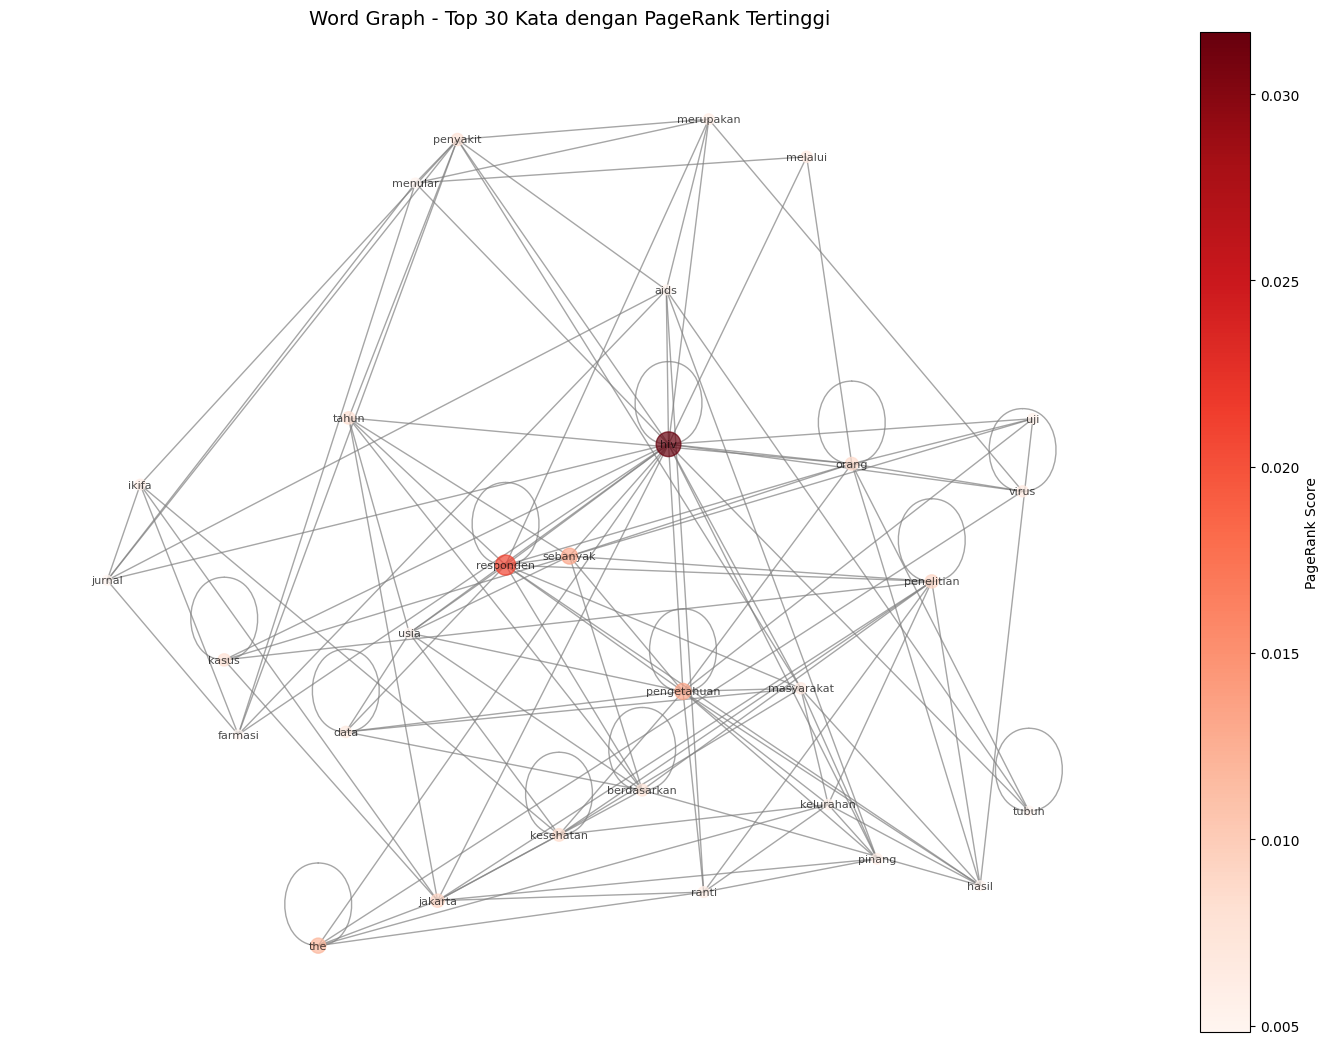

In [84]:
# Visualisasi graph dengan top 30 kata (untuk keterbacaan)
top_words = [word for word, score in sorted_pagerank[:30]]
subgraph = G.subgraph(top_words)

# Warna node berdasarkan PageRank score
node_colors = [pagerank_scores[node] for node in subgraph.nodes()]
node_sizes = [pagerank_scores[node] * 10000 for node in subgraph.nodes()]

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(subgraph, k=2, iterations=50)
nx.draw(subgraph, pos, 
        with_labels=True, 
        node_color=node_colors, 
        cmap=plt.cm.Reds,
        node_size=node_sizes, 
        font_size=8,
        edge_color='gray',
        alpha=0.7)
plt.title("Word Graph - Top 30 Kata dengan PageRank Tertinggi", fontsize=14)

# Fix colorbar dengan norm dan ax yang benar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='PageRank Score')

plt.tight_layout()
plt.show()